# Introducing Optimizers


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import os
import time
import copy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

os.environ["KERAS_BACKEND"] = "torch"
import keras_core as keras

Using PyTorch backend.


First generate a synthetic 3D dataset, add Gaussian noise. Then the noisy surface, and prepare training/test sets.

/home/ericpun1109/tf_ready/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


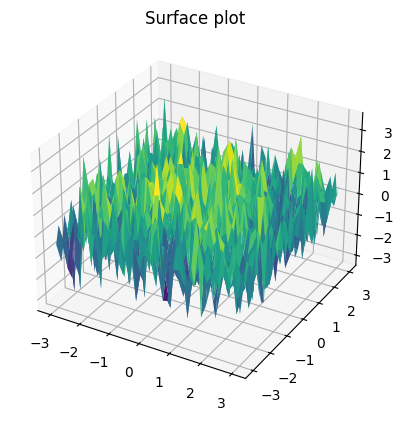

In [3]:
def f(x, y):
    return(torch.sin(0.7*(x**2 + y**2)) / (x**2 + y**2)**(0.8))

noise_level = 1
mesh_size = 40
t = torch.linspace(-3, 3, mesh_size)
x, y = torch.meshgrid(t, t)
z = f(x, y)
z_noisy = z + noise_level * torch.randn(mesh_size, mesh_size)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z_noisy,cmap='viridis', edgecolor='none')
ax.set_title('Surface plot')
plt.show()


# dataset creation
x_train = torch.vstack([x.ravel(), y.ravel()]).T
y_train = z_noisy.ravel()
y_test = z.ravel()

This class defines a fully connected neural network (`Net3L`) with up to seven hidden layers.  
It includes:
- a `forward` method for inference,  
- a custom `fit` method for training with any PyTorch optimizer, and  
- an `evaluate` method to compute mean squared error (MSE) on test data.  

The model is designed for regression tasks on 2D inputs.

In [4]:
class Net3L(nn.Module):

    def __init__(self, n_neurons_l1= 50, n_neurons_l2= 50,n_neurons_l3= 50,n_neurons_l4= 50,n_neurons_l5= 50,n_neurons_l6= 50, n_neurons_l7= 50):
        super(Net3L, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, n_neurons_l1),
            nn.ReLU(),
            nn.Linear(n_neurons_l1, n_neurons_l2), #  hidden layer
            nn.ReLU(),
            nn.Linear(n_neurons_l2, n_neurons_l3), #  hidden layer
            nn.ReLU(),
            nn.Linear(n_neurons_l3, n_neurons_l4), #  hidden layer
            nn.ReLU(),
            nn.Linear(n_neurons_l4, n_neurons_l5), #  hidden layer
            nn.ReLU(),
            nn.Linear(n_neurons_l5, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

    def fit(self, x_train, y_train, optimizer, batch_size, n_epochs_max):
        # Instantiate the train loader
        train_data = TensorDataset(x_train, y_train)
        train_loader = DataLoader(dataset =train_data, batch_size= batch_size, shuffle= True)
        # Beginning the optimization algorithm
        loss_list = []
        for n_epochs in range(n_epochs_max):
            # We train for a fixed number of epochs
            for x_batch, y_batch in train_loader:
                def closure():
                    optimizer.zero_grad()
                    output = self.forward(x_batch)
                    loss = nn.MSELoss()(output.squeeze(-1), y_batch)
                    loss.backward()
                    return loss
                loss = optimizer.step(closure)
            loss_list.append(loss.item())
        return loss_list

    def evaluate(self, x_test, y_test):
      y_pred = self(x_test).squeeze(-1)
      return (nn.MSELoss()(y_pred, y_test)).item()

This experiment compares different optimization algorithms on the same neural network.  
We create identical copies of the network so each optimizer starts from the same initialization.  
The optimizers tested are:

- **Vanilla SGD** (basic gradient descent)  
- **Plain SGD** (same as vanilla, used for comparison)  
- **SGD with Momentum + Nesterov**  
- **Adam** (adaptive learning rates)  
- **LBFGS** (quasi-Newton method with line search)  

Each network is trained for 3000 epochs with different batch sizes.  
We record the training loss curves, runtime, and evaluation performance for comparison.


In [ ]:
# Example with a list of optimizers (running this cell takes ~5min with the default parameters)
net = Net3L(50, 50,50 ,50, 50, 50 ,50)
# We create copies of this net so that every optimizer starts with the same initialization.
net_list = [copy.deepcopy(net) for i in range(5)]
# The number of epochs and other hyperparameters can (and should) be adapted to the point you're trying to make.
n_epochs = 3000
Vanilla_SGD = torch.optim.SGD(params=net_list[0].parameters(), lr=0.01)
Plain_SGD = torch.optim.SGD(params=net_list[1].parameters(), lr=0.01)
SGD_Momentum = torch.optim.SGD(params=net_list[2].parameters(), lr=0.01, momentum=0.9, nesterov= True)
Adam = torch.optim.Adam(params=net_list[3].parameters())
LBFGS = torch.optim.LBFGS(params=net_list[4].parameters(), lr=1, max_iter=1, line_search_fn='strong_wolfe')

optimizer_list = [Vanilla_SGD, Plain_SGD, SGD_Momentum, Adam, LBFGS]
batch_sizes_list = [1600, 800, 800, 400, 1600]
times_list = []
loss_meta_list = []
eval_list = []

for i, optimizer in enumerate(optimizer_list):
    t0 = time.time()
    loss_list = net_list[i].fit(x_train, y_train, optimizer= optimizer, batch_size= batch_sizes_list[i], n_epochs_max= n_epochs)
    t1 = time.time()
    times_list.append(t1-t0)
    loss_meta_list.append(loss_list)
    eval_list.append(net_list[i].evaluate(x_train, y_test))

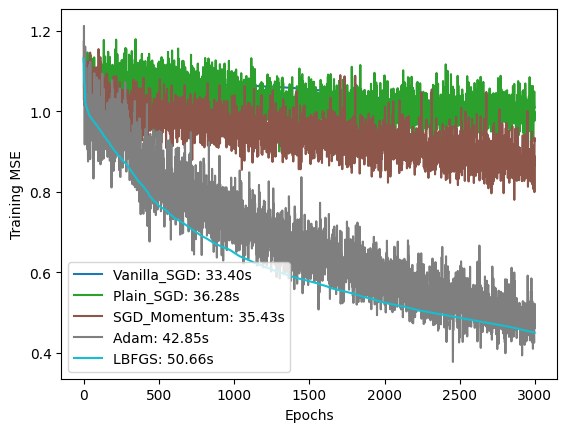

Training times:
Vanilla_SGD: 33.40s
Plain_SGD: 36.28s
SGD_Momentum: 35.43s
Adam: 42.85s
LBFGS: 50.66s
Evaluation performances:
Vanilla_SGD: 2.973e-02
Plain_SGD: 2.365e-02
SGD_Momentum: 9.731e-02
Adam: 4.978e-01
LBFGS: 5.197e-01


In [ ]:
# Define readable names for each optimizer
optimizer_names = ["Vanilla_SGD", "Plain_SGD", "SGD_Momentum", "Adam", "LBFGS"]

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Training MSE')

# Plot all losses (reversed like in your original)
for i in range(len(optimizer_list)):
    plt.plot(loss_meta_list[i], color=colors[i])

# Legend with optimizer names and times
plt.legend([f"{optimizer_names[i]}: {times_list[i]:.2f}s" for i in range(len(optimizer_list))])
plt.show()

# Print training times
print("Training times:")
for i, name in enumerate(optimizer_names):
    print(f"{name}: {times_list[i]:.2f}s")

# Print evaluation performances
print("Evaluation performances:")
for i, name in enumerate(optimizer_names):
    print(f"{name}: {eval_list[i]:.3e}")
